In [8]:
### Processors: 12 × Intel® Core™ i7-10710U CPU @ 1.10GHz
### Memory: 15,5 GiB of RAM

In [1]:
import psycopg2
import pandas as pd
import time
import seaborn as sns 
sns.set_palette("muted");
sns.set();
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector
from influxdb import InfluxDBClient

Databases = []
connections = []

#### Huom! Jos tulee virhekoodeja, kun yrität yhdistää tietokantoihin. Konttien host-osoite saattaa muuttua, jos kontti on sammunut jossakin välissä.
#### Docker inspect -kontin_nimi-

In [2]:
yugabyte = psycopg2.connect(host="172.19.0.1", 
                            port="5433", 
                            dbname="iiwari_org", 
                            user="yugabyte",
                            password="yugabyte")
Databases.append("YugabyteDB")
connections.append(yugabyte)

# query = "SELECT * FROM SensorData limit 80"
# start = time.time()
# cursor = yugabyte.cursor()
# cursor.execute(query)
# df = pd.DataFrame(cursor.fetchall())
# print(time.time() -start)
# df

#### CockroachDB Connection

In [3]:

cockroach = psycopg2.connect(
                database="iiwari",
                user='roach',
                host='172.18.0.1',
                port="26257"
)

Databases.append("CockroachDB")
connections.append(cockroach)

# query = "SELECT * FROM SensorData limit 80"
# start = time.time()
# cursor = cockroach.cursor()
# cursor.execute(query)
# df = pd.DataFrame(cursor.fetchall())
# print(time.time() -start)
# df

### TimescaleDB Connection

In [4]:
# Luodaan yhteys
timescaledb = psycopg2.connect(user = "postgres",
                              password = "password",
                              host = "172.17.0.3",
                              port = "5432",
                              dbname = "iiwari")

# Koko höskän luonti
# real    10m26,917s
# user    0m2,250s
# sys     0m5,637s

Databases.append("TimescaleDB")
connections.append(timescaledb)

# start = time.time()
# query ="SELECT * FROM SensorData limit 80"
# cursor = timescaledb.cursor()
# cursor.execute(query)
# df = pd.DataFrame(cursor.fetchall())
# print(time.time() -start)
# df

### MariaDB Connection

In [5]:
# En muistanut kellottaa, mutta populoinnissa meni noin.30min

mariadb = mysql.connector.connect(
    host="172.17.0.4",
    user="root",
    passwd="insert-password-here",
    database="iiwari_org"
)

Databases.append("MariaDB")
connections.append(mariadb)

# query = "SELECT * FROM SensorData limit 80"
# cursor = mariadb.cursor()
# cursor.execute(query)
# df = pd.DataFrame(cursor.fetchall())
# cursor.close()
# df

#### InfluxDB Connection

In [6]:

# koko höskän luonti
# real    119m57,521s
# user    0m3,748s
# sys     0m7,392s
influxdb = InfluxDBClient(host='172.17.0.5', 
                        port=8086, 
                        username='admin', 
                        password='teamfox',
                        database="iiwari_org")

Databases.append("InfluxDB")
connections.append(influxdb)


query =  "SELECT * FROM SensorData limit 80"


# result = influxdb.query(query)
# cpu_points = list(result.get_points())
# df = pd.DataFrame(list(cpu_points))
# df

In [12]:

def speed_test(connection):
    times = []
    start = time.time()
    query = "SELECT * FROM SensorData limit 1400000"
    if connection == influxdb:
        result = influxdb.query(query)
        cpu_points = list(result.get_points())
        # df = pd.DataFrame(list(cpu_points))
    else:
        cursor = connection.cursor()
        cursor.execute(query)
        cursor.fetchall()
    times.append(time.time()-start)
#         print(time.time() - start)
    
    return times

def scalability_test(connection):
    times = []
    start = time.time()
    for rows in range(0, 8000000, 1000000):
        query = "SELECT * FROM SensorData limit " + str(rows)+";"
        start = time.time()
        if connection == influxdb:
            pass
        else:
            cursor = connection.cursor()

            cursor.execute(query)
            cursor.fetchall()
        times.append(time.time()-start)
#         print(time.time()-start)

    return times

def speed_test_and_to_dataframe(connection):
    times = []
    query = "SELECT * FROM SensorData limit 1400000"
    
    if connection == influxdb:
        result = influxdb.query(query)
        cpu_points = list(result.get_points())
        start = time.time()
        df = pd.DataFrame(list(cpu_points))
        times.append(time.time()-start)
    else:
        cursor = connection.cursor()
        cursor.execute(query)
        start = time.time()
        df = pd.DataFrame(cursor.fetchall())
        times.append(time.time()-start)
    return times

def speed_test_condition(connection):
    times = []
    start = time.time()
    query = "SELECT * FROM SensorData WHERE z = 0 and x != 250"
    if connection == influxdb:
        result = influxdb.query(query)
        cpu_points = list(result.get_points())
        df = pd.DataFrame(list(cpu_points))
    else:
        cursor = connection.cursor()
        cursor.execute(query)
        df = pd.DataFrame(cursor.fetchall())
    times.append(time.time()-start)

    return times

db_speed_times = []
db_scalability_times = []
db_to_dataframe_tiems = []
db_speed_condition_times = []

for connection in connections:    
    db_speed_times.append(speed_test(connection))
    db_scalability_times.append(scalability_test(connection))
    db_to_dataframe_tiems.append(speed_test_and_to_dataframe(connection))
    db_speed_condition_times.append(speed_test_condition(connection))

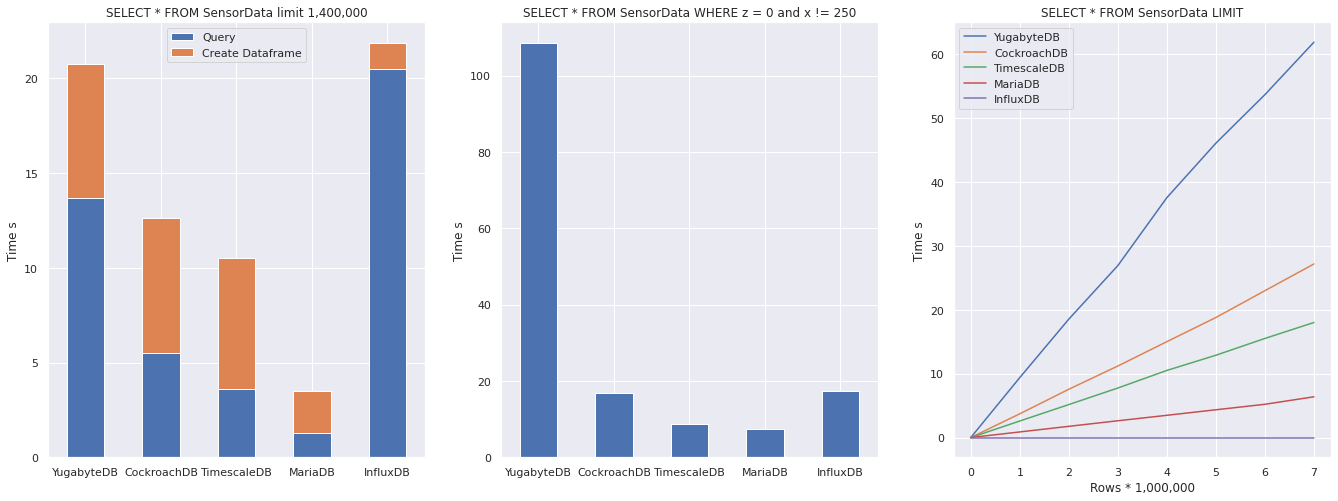

In [34]:

def get_graphs(db_speed_times, db_to_dataframe_tiems, db_speed_condition_times, db_scalability_times, Databases):

    fig, axes = plt.subplots(1,3, figsize=(23,8), squeeze=False)

    asd = {}
    sdf = {}
    for db in range(len(Databases)):
        asd.update(pd.DataFrame({Databases[db]:db_speed_times[db]}, index = ["Query"]))
        sdf.update(pd.DataFrame({Databases[db]:db_to_dataframe_tiems[db]},  index = ["Create Dataframe"]))

    dd = pd.DataFrame(asd)
    dd = dd.append(pd.DataFrame(sdf))
    dd.T.plot(kind="bar", stacked = True, ax=axes[0,0]).set_title("SELECT * FROM SensorData limit 1,400,000")
    axes[0][0].legend(loc=9)
    plt.setp(axes[0,0].get_xticklabels(), rotation=0)
    
    lll = {}
    for db in range(len(Databases)):
        lll.update(pd.DataFrame({Databases[db]:db_speed_condition_times[db]}))
    cond = pd.DataFrame(lll)
    cond.T.plot(kind="bar", ax=axes[0,1], legend=None).set_title("SELECT * FROM SensorData WHERE z = 0 and x != 250")

#     plt.ylabel("Time s")
    plt.setp(axes[0,1].get_xticklabels(), rotation=0)
    
    sca = {}
    for db in range(len(Databases)):
        sca.update(pd.DataFrame({Databases[db]:db_scalability_times[db]}))
        sss = pd.DataFrame(sca)
    a = sss.plot(kind="line", ax=axes[0,2]).set_title("SELECT * FROM SensorData LIMIT")
    plt.ylabel("Time s")
    plt.xlabel("Rows * 1,000,000")
    plt.setp(axes[0:], ylabel='Time s')
    return plt.show()

get_graphs(db_speed_times, db_to_dataframe_tiems, db_speed_condition_times, db_scalability_times, Databases)

### Aijempia koodeja

In [ ]:
### Aikaisempi versio
def plot_benchmarks(db_scalability_times, db_speed_times, db_to_dataframe_tiems, db_speed_condition_times, Databases):
    Databases = ["TimescaleSB", "MariaDB", "InfluxDB"]
    fig, axes = plt.subplots(2,2, figsize=(16, 11))
    for i in range(len(db_scalability_times)):
        
        sns.lineplot(ax=axes[0][0],x=[x for x in range(len(db_speed_times[i]))], y=db_speed_times[i]).set_title("SELECT * FROM SensorData limit 14,000,000")
        axes[0][0].set_ylabel("Time s")
        axes[0][0].xaxis.set_major_locator(plt.MultipleLocator(1))
        axes[0][0].set_xlabel("Number of iterations")
        
        sns.lineplot(ax=axes[0][1],x=[x for x in range(len(db_to_dataframe_tiems[i]))], y=db_to_dataframe_tiems[i]).set_title("SELECT * FROM SensorData limit 14,000,000 + dataframe")
        axes[0][1].set_ylabel("Time s")
        axes[0][1].xaxis.set_major_locator(plt.MultipleLocator(1))
        axes[0][1].set_xlabel("Number of iterations")
        
        sns.lineplot(ax=axes[1][0],x=[x for x in range(len(db_speed_condition_times[i]))], y=db_speed_condition_times[i]).set_title("SELECT * FROM SensorData WHERE node_id = 3200 + dataframe")
        axes[1][0].set_ylabel("Time s")
        axes[1][0].xaxis.set_major_locator(plt.MultipleLocator(1))
        axes[1][0].set_xlabel("Number of iterations")
        

        sns.lineplot(ax=axes[1][1],x=[x for x in range(len(db_scalability_times[i]))], y=db_scalability_times[i]).set_title("SELECT * FROM SensorData LIMIT")
        axes[1][1].xaxis.set_major_locator(plt.MultipleLocator(1))
        axes[1][1].set_ylabel("Time s")
        axes[1][1].set_xlabel("Number of rows *100,000")
    
    plt.suptitle('Benchmarks ',fontsize=20)
    axes[0][0].legend(title='Database', loc='upper center', labels=Databases)
    axes[0][1].legend(title='Database', loc='upper center', labels=Databases)
    axes[1][0].legend(title='Database', loc='upper center', labels=Databases)
    axes[1][1].legend(title='Database', loc='upper center', labels=Databases)

    plt.show()
    
plot_benchmarks(db_scalability_times, db_speed_times, db_to_dataframe_tiems, db_speed_condition_times, Databases)

In [ ]:
Databases = ["TimescaleSB", "MariaDB", "InfluxDB"]
def stacked_graphs(Databases, db_speed_times, db_to_dataframe_tiems):
    
    df = pd.DataFrame()
    asd = {}
    sdf = {}
    for db in range(len(Databases)):
        asd.update(pd.DataFrame({Databases[db]:db_speed_times[db]}, index = ["Query"]))
        sdf.update(pd.DataFrame({Databases[db]:db_to_dataframe_tiems[db]},  index = ["Query + Dataframe"]))

    dd = pd.DataFrame(asd)
    dd = dd.append(pd.DataFrame(sdf))
    return dd.T.plot(kind="bar", stacked = True, figsize=(7,5)).set_ylabel("Time")
stacked_graphs(Databases, db_speed_times, db_to_dataframe_tiems);

In [ ]:
db_speed_times

In [ ]:
speed_and_dataframe_times

In [ ]:
db_speed_times